# Training

## Libraries

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from glob import glob
import os
import pandas as pd

## Dataset loading

In [56]:
'''
Dataset structure:
audio/
├── train
│  ├── class
│  │   ├── 1.wav
│  │   ├── 2.wav
│  │   ├── ...
│  └── ...
'''
def load_dataset(type="train", modality="audio"):
    # Path to audio folder
    if modality == "audio":
        audio_folder = "data/{}".format(type)
        file_format = "wav"
    elif modality == "vibration":
        audio_folder = "data-vibration/{}".format(type)
        file_format = "csv"
    # audio_folder = "data/{}".format(type)
    # Extract all classes available by reading the subfolder names
    classes = sorted(os.listdir(audio_folder))
    # Extract all audio files available for each class as a separate list
    audio_files = {}
    for c in classes:
        # Get all files in the class folder
        audio_files[c] = sorted(glob(os.path.join(audio_folder, c, "*.{}".format(file_format))))

    # print("Classes: ", classes)
    # print(audio_files)
    return audio_files, classes

# load_dataset("train")


## Feature extractions

In [ ]:
def zcr(frame, frame_length):
    """Compute Zero Crossing Rate (ZCR)"""
    # Count the number of times the signal changes sign
    zero_crossings = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
    return zero_crossings / frame_length
    # return librosa.feature.zero_crossing_rate(frame, frame_length=frame_length)[0, 0]

def rms(frame):
    """Compute Root Mean Square (RMS)"""
    # RMS measures the average power of the signal
    # return np.sqrt(np.sum(frame**2) / len(frame))
    return np.sqrt(np.mean(frame**2))

def temporal_entropy(frame):
    """Compute Temporal Entropy"""
    # Temporal entropy measures the distribution of energy in the time domain
    hist = np.histogram(frame, bins=8, range=(np.min(frame), np.max(frame)))[0]
    prob = hist / np.sum(hist)
    prob = prob[prob > 0]  # Avoid log(0)
    return -np.sum(prob * np.log2(prob))

def compute_fft(y, frame_length, hop_length):
    """Compute the Short-Time Fourier Transform (STFT) using NumPy."""
    return librosa.stft(y, n_fft=frame_length, hop_length=hop_length, window='hann', center=False)

def spectral_centroid(S, sr):
    """Compute Spectral Centroid"""

    return librosa.feature.spectral_centroid(S=S, sr=sr)

def spectral_rolloff(S, sr, roll_percent=0.85):
    """Compute Spectral Rolloff"""

    return librosa.feature.spectral_rolloff(S=S, sr=sr, roll_percent=roll_percent)

def spectral_flatness(S):
    """Compute Spectral Flatness"""
    # Spectral flatness is the ratio of the geometric mean to the arithmetic mean of the spectrum
    geometric_mean = np.exp(np.mean(np.log(S + 1e-10)))  # Add small value to avoid log(0)
    arithmetic_mean = np.mean(S)
    return geometric_mean / arithmetic_mean
    # return librosa.feature.spectral_flatness(S=S)

def band_ratio(S, sr, frame_length):
    """Compute Band Energy Ratio (low vs mid frequencies)"""
    # Band energy ratio compares the energy in different frequency bands
    freqs = librosa.fft_frequencies(sr=sr, n_fft=frame_length)
    low_band = (freqs >= 100) & (freqs < 1000)
    mid_band = (freqs >= 1000) & (freqs < 4000)
    low_energy = np.sum(S[low_band, :], axis=0)
    mid_energy = np.sum(S[mid_band, :], axis=0)
    return mid_energy / (low_energy + 1e-10)
    # Add small value to avoid division by zero

In [4]:
def extract_audio_features(file_path, sr, frame_length=2048, hop_length=512):
    """Extract material sound features compatible with HDC requirements"""
    
    # Load audio with optimal parameters for material sounds
    y, sr = librosa.load(file_path, sr=sr, duration=5.0)  # 16kHz sampling
    
    # Frame-based processing
    frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
    num_frames = frames.shape[1]
    # print("Number of frames: ", len(y))
    
    # Initialize feature arrays with zeros
    feature_names = ['zcr', 'rms', 'temporal_entropy', 'spectral_centroid', 'spectral_rolloff', 'spectral_flatness', 'band_ratio']
    features = {name: np.zeros(num_frames) for name in feature_names}

    # Time-domain features
    for i in range(num_frames):
        frame = frames[:, i]
        features['zcr'][i] = zcr(frame, frame_length)
        # print("Frame", i, features['zcr'][i])
        features['rms'][i] = rms(frame)
        features['temporal_entropy'][i] = temporal_entropy(frame)

    # Frequency-domain features
    S = np.abs(librosa.stft(y, n_fft=frame_length, hop_length=hop_length))
    features['spectral_centroid'] = spectral_centroid(S, sr)
    features['spectral_rolloff'] = spectral_rolloff(S, sr)
    features['spectral_flatness'] = spectral_flatness(S)

    # Band energy ratio (low vs mid frequencies)
    features['band_ratio'] = band_ratio(S, sr, frame_length)

    # Aggregate statistics for HDC encoding
    feature_vector = [
        np.mean(features['zcr']), np.std(features['zcr']),
        np.mean(features['rms']), np.max(features['rms']),
        np.mean(features['temporal_entropy']),
        np.mean(features['spectral_centroid']),
        np.mean(features['spectral_rolloff']),
        np.mean(features['spectral_flatness']),
        np.mean(features['band_ratio'])
    ]
    # print(feature_vector)
    return feature_vector

# extract_audio_features("data/test/metal/artemis_recording_31.wav", sr=8000)

In [5]:
def extract_vibration_features(file_path, frame_length=2048, hop_length=512):
    """Extract material vibration features compatible with HDC requirements"""
    
    # laod vibration data from CSV
    csv_values = pd.read_csv(file_path, header=None)
    # convert to numpy array
    csv_values = csv_values.to_numpy().flatten()
    
    # clip the values to [0, 1023]
    csv_values = np.clip(csv_values, 0, 1023)
    # Normalize the 10-bit sensor values to the range [-1, 1]
    y = (csv_values - 512) / 512.0  # Assuming 10-bit values range from 0 to 1023
    
    # Frame-based processing
    frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
    num_frames = frames.shape[1]
    
    # Initialize feature arrays with zeros
    feature_names = ['zcr', 'rms', 'temporal_entropy', 'spectral_centroid', 'spectral_rolloff', 'spectral_flatness', 'band_ratio']
    features = {name: np.zeros(num_frames) for name in feature_names}

    # Time-domain features
    for i in range(num_frames):
        frame = frames[:, i]
        features['zcr'][i] = zcr(frame, frame_length)
        features['rms'][i] = rms(frame)
        features['temporal_entropy'][i] = temporal_entropy(frame)

    # Frequency-domain features
    S = np.abs(librosa.stft(y, n_fft=frame_length, hop_length=hop_length))
    features['spectral_centroid'] = spectral_centroid(S, sr=1)  # sr=1 since it's not audio
    features['spectral_rolloff'] = spectral_rolloff(S, sr=1)
    features['spectral_flatness'] = spectral_flatness(S)

    # Band energy ratio (low vs mid frequencies)
    features['band_ratio'] = band_ratio(S, sr=1, frame_length=frame_length)

    # Aggregate statistics for HDC encoding
    feature_vector = [
        np.mean(features['zcr']), np.std(features['zcr']),
        np.mean(features['rms']), np.max(features['rms']),
        np.mean(features['temporal_entropy']),
        np.mean(features['spectral_centroid']),
        np.mean(features['spectral_rolloff']),
        np.mean(features['spectral_flatness']),
        0
        # np.mean(features['band_ratio'])
    ]
    # print(feature_vector)
    return feature_vector

# Example usage
# csv_values = df.iloc[:, 0].to_numpy()  # Assuming `df` contains the CSV data
# vibration_features = extract_vibration_features(csv_values)


## HDC operations

In [24]:
# --- Feature Setup ---
feature_names = [
    'zcr_mean', 'zcr_std', 'rms_mean', 'rms_max',
    'entropy_mean', 'spectral_centroid_mean', 'spectral_rolloff_mean',
    'spectral_flatness_mean', 'band_ratio_mean'
]

# Selectively chosen important feature pairs
important_pairs = [
    ('zcr_mean', 'entropy_mean'),
    ('rms_mean', 'spectral_rolloff_mean'),
    ('spectral_flatness_mean', 'spectral_centroid_mean'),
    ('rms_max', 'band_ratio_mean')
]

# --- 1. Feature name codebook (via permutation) ---
def generate_feature_codebook(feature_names, D):
    base = np.random.randint(0, 2, D, dtype=np.uint8)
    return {name: np.roll(base, i + 1) for i, name in enumerate(feature_names)}

# --- 2. Pre-generate value level hypervectors ---
def generate_value_level_hvs(levels, D):
    level_hvs = []
    for level in range(levels):
        hv = np.zeros(D, dtype=np.uint8)
        if level > 0:
            n_bits = level * D // levels
            indices = np.random.choice(D, n_bits, replace=False)
            hv[indices] = 1
        level_hvs.append(hv)
    return level_hvs

# --- 3. Map value to nearest level HV ---
def get_value_hv(levels, value, level_hvs):
    level = min(levels - 1, max(0, int(value * levels)))
    return level_hvs[level]

# --- 4. Encode single audio feature vector ---
def encode_feature_vector(features, codebook, level_hvs, D, levels):
    assert len(features) == len(codebook)
    
    feature_dict = dict(zip(codebook.keys(), features))
    hvs = []

    # Step 1: Encode individual features (key ⊙ value)
    for name, value in feature_dict.items():
        feat_hv = np.bitwise_xor(codebook[name], get_value_hv(levels, value, level_hvs))
        hvs.append(feat_hv.astype(np.int16))

    # Step 2: Encode selected feature-pair interactions (bound pair HVs)
    for f1, f2 in important_pairs:
        hv1 = np.bitwise_xor(codebook[f1], get_value_hv(levels, feature_dict[f1], level_hvs))
        hv2 = np.bitwise_xor(codebook[f2], get_value_hv(levels, feature_dict[f2], level_hvs))
        pair_hv = np.bitwise_xor(hv1, hv2)
        hvs.append(pair_hv.astype(np.int16))

    # Optional: visualize before bundling
    # plt.figure(figsize=(10, 8))
    # plt.imshow(hvs, aspect='auto', cmap='hot', vmin=0, vmax=1)
    # plt.colorbar()
    
    # Step 3: Final bundling (majority vote)
    hvs = np.array(hvs)
    sum_hv = np.sum(hvs, axis=0)
    threshold = len(hvs) // 2
    final_hv = (sum_hv > threshold).astype(np.uint8)
    # print(sum_hv.shape, hvs.shape, len(hvs),final_hv.shape)

    return final_hv

# --- 5. Encode both audio and vibration features ---

def encode_audio_vibration_features(audio_file, vibration_file, audio_codebook, vibration_codebook, level_hvs, D, levels):
    audio_hv = encode_feature_vector(audio_file, audio_codebook, level_hvs, D, levels)
    vibration_hv = encode_feature_vector(vibration_file, vibration_codebook, level_hvs, D, levels)

    # Bundle the two HVs 
    # hvs = np.array([audio_hv, vibration_hv])
    # sum_hv = np.sum(hvs, axis=0)
    # threshold = len(hvs) // 2
    # final_hv = (sum_hv > threshold).astype(np.uint8)

    final_hv = np.bitwise_xor(audio_hv, vibration_hv)
    return final_hv

#######


## Model training

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def train_hd_classifier(dataset, labels, codebook, level_hvs, D, levels, epochs):
    """
    dataset: list or np.array of normalized feature vectors (N x 9)
    labels: list or np.array of corresponding class labels (N)
    codebook: feature-name -> HVs (symbolic keys of 9 features)
    level_hvs: list of pre-generated value level HVs
    """

    dataset = np.copy(dataset)
    labels = np.copy(labels)

    num_classes = len(np.unique(labels))
    real_class_hvs = np.zeros((num_classes, D), dtype=np.int16)

    N = len(dataset)

    for epoch in range(epochs):
        for i in range(N):
            query_hv = dataset[i]
            y_true = labels[i]

            # Binarize class HVs
            bin_class_hvs = (real_class_hvs >= 0).astype(np.uint8)

            # Predict using Hamming distance
            predictions = np.sum(query_hv != bin_class_hvs, axis=1)
            y_pred = np.argmin(predictions)

            # OnlineHD-style update
            if y_pred != y_true:
                real_class_hvs[y_true] += query_hv
                real_class_hvs[y_pred] -= query_hv

        # Shuffle
        indices = np.random.permutation(N)
        dataset = dataset[indices]
        labels = labels[indices]

    final_class_hvs = np.zeros((num_classes, D), dtype=np.int16)
    final_class_hvs = (real_class_hvs >= 0).astype(np.uint8)
    return final_class_hvs

def predict_hd(query_hv, class_hvs):
    """
    Predict label for a query hypervector using Hamming distance.
    """
    distances = [np.sum(query_hv != class_hv) for class_hv in class_hvs]
    return np.argmin(distances)

def evaluate_hd(vectors, labels, class_hvs):
    correct = 0
    y_preds = []
    for query_hv, y_true in zip(vectors, labels, strict=True):
        y_pred = predict_hd(query_hv, class_hvs)
        y_preds.append(y_pred)
        if y_pred == y_true:
            correct += 1

    # # Plot confusion matrix using numpy and matplotlib
    # cm = confusion_matrix(labels, y_preds)
    # plt.figure(figsize=(8, 6))
    # plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # plt.title("Confusion Matrix")
    # plt.colorbar()

    # # Add labels to the axes
    # tick_marks = np.arange(len(id_to_label))
    # plt.xticks(tick_marks, [id_to_label[i] for i in range(len(id_to_label))], rotation=30, fontsize=12)
    # plt.yticks(tick_marks, [id_to_label[i] for i in range(len(id_to_label))], fontsize=12)

    # # Annotate each cell with the numeric value
    # for i in range(cm.shape[0]):
    #     for j in range(cm.shape[1]):
    #         plt.text(j, i, format(cm[i, j], 'd'),
    #                  horizontalalignment="center",
    #                  color="white" if cm[i, j] > cm.max() / 2 else "black",
    #                  fontsize=12)

    # plt.ylabel("True Label", fontsize=12)
    # plt.xlabel("Predicted Label", fontsize=12)
    # plt.tight_layout()
    # plt.show()

    return correct / len(labels)



## Audio model

In [64]:
import time

# --- Main execution ---

# Load dataset
dataset = [] # audio features
labels = [] # class ids

audio_files, classes = load_dataset("train", modality="audio")

# Prepare a dictionary of labels and their IDs
label_to_id = {class_name: idx for idx, class_name in enumerate(classes)}
id_to_label = {idx: class_name for class_name, idx in label_to_id.items()}

# Extract features
for _, class_name in enumerate(classes):
    for file_path in audio_files[class_name]:
        features = extract_audio_features(file_path, sr=8000)
        dataset.append(features)
        labels.append(label_to_id[class_name])


# Normalize feature-wise (0–1 scaling)
dataset = np.array(dataset)
# save the (min, max) values for each feature
dataset_min = np.min(dataset, axis=0)
dataset_max = np.max(dataset, axis=0)
dataset = (dataset - dataset.min(axis=0)) / (dataset.max(axis=0) - dataset.min(axis=0))


# generate codebooks
D = 250  # Hypervector dimensionality
LEVELS = 32 # quantization levels
np.random.seed(42)
codebook = generate_feature_codebook(feature_names, D)
value_level_hvs = generate_value_level_hvs(LEVELS, D)

vectors = [] # encode dataset vectors

for features in dataset:
    encoded_hv = encode_feature_vector(features, codebook, value_level_hvs, D, LEVELS)
    vectors.append(encoded_hv)

vectors = np.array(vectors)
labels = np.array(labels)


# create weights folder if it doesn't exist
if not os.path.exists("weights/audio/"):
    os.makedirs("weights/audio")

def timeit(fn, *args, **kwargs):
    t0 = time.perf_counter(); out = fn(*args, **kwargs)
    return out, time.perf_counter() - t0
# for i in range(20):
    # train the classifier
class_hvs, training_time = timeit(train_hd_classifier, vectors, labels, codebook, value_level_hvs, D, LEVELS, epochs=10)

print(f"Training time: {training_time:.2f} seconds")

# # convert class_hvs to boolean array
# class_hvs = (class_hvs >= 0).astype(np.dtypes.BoolDType())
# # Save the trained model
np.save("weights/audio/class_hvs.npy", class_hvs) # save class hypervectors
np.save("weights/audio/codebook.npy", codebook) # save codebook
np.save("weights/audio/value_level_hvs.npy", value_level_hvs) # save value level hypervectors
np.save("weights/audio/label_to_id.npy", label_to_id) # save label_to_id mapping
np.save("weights/audio/id_to_label.npy", id_to_label) # save id_to_label mapping
np.save("weights/audio/dataset_min.npy", dataset_min) # save dataset min
np.save("weights/audio/dataset_max.npy", dataset_max) # save dataset max

acc = evaluate_hd(vectors, labels, class_hvs)
print(f"Training accuracy: {acc * 100:.2f}%")
aud_test()



Training time: 0.01 seconds
Training accuracy: 100.00%
Testing accuracy: 100.00%
Inference time: 0.00 seconds
Testing accuracy: 100.00%


In [65]:
# --- Main execution ---
def aud_test():
    # Load dataset
    dataset = [] # audio features
    labels = [] # class ids

    audio_files, classes = load_dataset("test", modality="audio")

    # Prepare a dictionary of labels and their IDs
    label_to_id = np.load("weights/audio/label_to_id.npy", allow_pickle=True).item()
    id_to_label = np.load("weights/audio/id_to_label.npy", allow_pickle=True).item()

    # Extract features
    for label_idx, class_name in enumerate(classes):
        for file_path in audio_files[class_name]:
            features = extract_audio_features(file_path, sr=8000)
            dataset.append(features)
            labels.append(label_to_id[class_name])

    # Load the min and max values for normalization
    dataset_min = np.load("weights/audio/dataset_min.npy", allow_pickle=True)
    dataset_max = np.load("weights/audio/dataset_max.npy", allow_pickle=True)
    dataset_max = np.load("weights/dataset_max.npy", allow_pickle=True)


    # Normalize feature-wise (0–1 scaling)
    dataset = np.array(dataset)
    # Normalize the dataset using the saved min and max values
    dataset = (dataset - dataset_min) / (dataset_max - dataset_min)
    # dataset = (dataset - dataset.min(axis=0)) / (dataset.max(axis=0) - dataset.min(axis=0))


    # generate codebooks
    # D = 1000  # Hypervector dimensionality
    # LEVELS = 16 # quantization levels
    np.random.seed(42)
    codebook = np.load("weights/audio/codebook.npy", allow_pickle=True).item()
    value_level_hvs = np.load("weights/audio/value_level_hvs.npy", allow_pickle=True)

    vectors = [] # encode dataset vectors

    for features in dataset:
        encoded_hv = encode_feature_vector(features, codebook, value_level_hvs, D, LEVELS)
        vectors.append(encoded_hv)

    vectors = np.array(vectors)
    labels = np.array(labels)

    # train the trained class hypervectors
    class_hvs = np.load("weights/audio/class_hvs.npy", allow_pickle=True)

    # Evaluate training performance
    acc = evaluate_hd(vectors, labels, class_hvs)
    print(f"Testing accuracy: {acc * 100:.2f}%")


## Export weights to C 

In [36]:
# save class_hvs, codebook, value_level_hvs, label_to_id 
# to a C header file
def save_to_c_header(class_hvs, codebook, value_level_hvs, label_to_id):
    with open("weights.h", "w") as f:
        f.write("#ifndef HD_WEIGHTS_H\n")
        f.write("#define HD_WEIGHTS_H\n\n")
        f.write("#include <stdint.h>\n\n")
        
        # Define constants
        f.write("#define D {}\n".format(len(class_hvs[0])))
        f.write("#define NUM_CLASSES {}\n".format(len(class_hvs)))
        f.write("#define NUM_FEATURES {}\n".format(len(codebook)))
        f.write("#define LEVELS {}\n\n".format(len(value_level_hvs)))

        # Save class hypervectors
        f.write("const uint8_t class_hvs[NUM_CLASSES][D] = {\n")
        for hv in class_hvs:
            f.write("  {")
            f.write(", ".join(map(str, hv)))
            f.write("},\n")
        f.write("};\n\n")

        # Save codebook
        f.write("const uint8_t codebook[NUM_FEATURES][D] = {\n")
        features = list(codebook.keys())
        for feature_name in features:
            hv = codebook[feature_name]
            f.write("  {")
            f.write(", ".join(map(str, hv)))
            f.write("}}, // {}\n".format(feature_name))
        f.write("};\n\n")

        # Save value level hypervectors
        f.write("const uint8_t value_level_hvs[LEVELS][D] = {\n")
        for hv in value_level_hvs:
            f.write("  {")
            f.write(", ".join(map(str, hv)))
            f.write("},\n")
        f.write("};\n\n")

        # Save label to ID mapping
        f.write("const char* label_names[NUM_CLASSES] = {\n")
        for label_name, idx in sorted(label_to_id.items(), key=lambda x: x[1]):
            f.write('  "{}",\n'.format(label_name))
        f.write("};\n\n")

        f.write("#endif // HD_WEIGHTS_H\n")

# Save to C header file
save_to_c_header(class_hvs, codebook, value_level_hvs, label_to_id)

In [17]:
import librosa
import numpy as np
import soundfile as sf
import sys

def convert_to_pcm16(input_file, output_file, target_sr=8000):
    # Load audio using librosa, forcing mono and resampling as needed.
    # The samples will be in float32 format in range [-1, 1]
    # y, sr = librosa.load(input_file, sr=target_sr, duration=5.0)
    y, sr = librosa.load(input_file[0], sr=target_sr, duration=5.0)
    # print(len(y), y[:10])
    # save the output y into a c header file 
    with open("audio_data_new.h", "w") as f:
        f.write("#ifndef AUDIO_DATA_H\n")
        f.write("#define AUDIO_DATA_H\n\n")
        f.write("#include <stdint.h>\n\n")
        f.write(f"#define AUDIO_LENGTH {len(y)}\n\n")

        for file in input_file:
            name = file.split("/")[2]
            print(name)
            y, sr = librosa.load(file, sr=target_sr, duration=5.0)

            f.write(f"const float audio_data_vector_{name}[AUDIO_LENGTH] = {{\n")
            # f.write("const float audio_data_vector[AUDIO_LENGTH] = {\n")
            f.write(", ".join(f"    {sample:.6f}" for sample in y))
            f.write("\n};\n\n")

        f.write("#endif // AUDIO_DATA_H\n")

if __name__ == '__main__':
    # if len(sys.argv) != 3:
    #     print("Usage: python convert_to_pcm16.py <input_audio_file> <output_wav_file>")
    # else:
    # input_file = sys.argv[1]
    # output_file = sys.argv[2]
    input_files = ["data/test/sandpaper/artemis_recording_33.wav",
                        "data/test/wood/artemis_recording_33.wav",
                        "data/test/metal/artemis_recording_33.wav",
                        "data/test/cloth/artemis_recording_33.wav",
                        "data/test/grass/artemis_recording_33.wav",]
    convert_to_pcm16(input_files, "converted.wav")
    # convert_to_pcm16("data/test/sandpaper/artemis_recording_33.wav", "converted.wav")


sandpaper
wood
metal
cloth
grass


In [49]:
extract_audio_features("data/test/metal/artemis_recording_33.wav", sr=8000)

## Vibration model

In [37]:
# Load dataset
dataset = [] # audio features
labels = [] # class ids

audio_files, classes = load_dataset(type="train", modality="vibration")

{
# # all files are csv, so load and visualise all the files of a class in a single plot. and each subplot should be a different class
# fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

# for idx, class_name in enumerate(classes):
#     # Load all CSV files of a class from audio_files
#     csv_files = audio_files[class_name]
#     ax = axes[idx]
#     for i, file_path in enumerate(csv_files):
#         df = pd.read_csv(file_path, header=None)
#         x = df.iloc[:, 0].to_numpy()
#         # clip the max and min values to 1024 and 0
#         x = np.clip(x, 0, 1024)
#         ax.plot(x, label=f"File {i+1}")
#     ax.set_title(f"Vibration Data for Class: {class_name}")
#     ax.set_ylabel("Amplitude")
#     # ax.legend(loc="upper right", fontsize="small")

# axes[-1].set_xlabel("Time")
# plt.tight_layout()
# plt.show()
}


# Prepare a dictionary of labels and their IDs
label_to_id = {class_name: idx for idx, class_name in enumerate(classes)}
id_to_label = {idx: class_name for class_name, idx in label_to_id.items()}

# Extract features
for _, class_name in enumerate(classes):
    for file_path in audio_files[class_name]:
        # features = extract_audio_features(file_path, sr=8000)
        features = extract_vibration_features(file_path, frame_length=2048, hop_length=512)

        dataset.append(features)
        labels.append(label_to_id[class_name])


dataset = np.array(dataset) 

# save the (min, max) values for each feature
dataset_min = np.min(dataset, axis=0)
dataset_max = np.max(dataset, axis=0)

# Avoid normalizing the last column as all values are the same
for i in range(dataset.shape[1] - 1):
    dataset[:, i] = (dataset[:, i] - dataset_min[i]) / (dataset_max[i] - dataset_min[i])

# Avoid normalizing the last column as all values are the same
for i in range(dataset.shape[1] - 1):
    dataset[:, i] = (dataset[:, i] - dataset_min[i]) / (dataset_max[i] - dataset_min[i])

# Keep the last column unchanged
# dataset[:, -1] = dataset[:, -1]

# generate codebooks
D = 10000  # Hypervector dimensionality
LEVELS = 128 # quantization levels

# d = [100, 500, 1000, 5000, 10000]
d = [5000]
l = [64]


for D in d:
    for LEVELS in l:

        np.random.seed(42)
        codebook = generate_feature_codebook(feature_names, D)
        value_level_hvs = generate_value_level_hvs(LEVELS, D)
        vectors = [] # encode dataset vectors

        for features in dataset:
            encoded_hv = encode_feature_vector(features, codebook, value_level_hvs, D, LEVELS)
            vectors.append(encoded_hv)

        vectors = np.array(vectors)
        labels = np.array(labels)


        # create weights folder if it doesn't exist
        if not os.path.exists("weights/vibration"):
            os.makedirs("weights/vibration")

        # for i in range(20):
            # train the classifier
        class_hvs = train_hd_classifier(vectors, labels, codebook, value_level_hvs, D, LEVELS, epochs=20)


        # # Save the trained model
        np.save("weights/vibration/class_hvs.npy", class_hvs) # save class hypervectors
        np.save("weights/vibration/codebook.npy", codebook) # save codebook
        np.save("weights/vibration/value_level_hvs.npy", value_level_hvs) # save value level hypervectors
        np.save("weights/vibration/label_to_id.npy", label_to_id) # save label_to_id mapping
        np.save("weights/vibration/id_to_label.npy", id_to_label) # save id_to_label mapping
        np.save("weights/vibration/dataset_min.npy", dataset_min) # save dataset min
        np.save("weights/vibration/dataset_max.npy", dataset_max) # save dataset max

        acc = evaluate_hd(vectors, labels, class_hvs)
        print(f"D {D} L {LEVELS}\nTraining accuracy: {acc * 100:.2f}%")
        vib_test()
        # print(f"Training accuracy: {acc * 100:.2f}%")



D 5000 L 64
Training accuracy: 78.00%
Testing accuracy: 48.00%


In [27]:
# --- Main execution ---
def vib_test():
    # Load dataset
    dataset = [] # audio features
    vibration_labels = [] # class ids

    audio_files, classes = load_dataset("test", modality="vibration")

    # Prepare a dictionary of labels and their IDs
    label_to_id = np.load("weights/vibration/label_to_id.npy", allow_pickle=True).item()
    id_to_label = np.load("weights/vibration/id_to_label.npy", allow_pickle=True).item()

    # Extract features
    for label_idx, class_name in enumerate(classes):
        for file_path in audio_files[class_name]:
            features = extract_vibration_features(file_path, frame_length=2048, hop_length=512)
            dataset.append(features)
            vibration_labels.append(label_to_id[class_name])

    # Load the min and max values for normalization
    dataset_min = np.load("weights/vibration/dataset_min.npy", allow_pickle=True)
    dataset_max = np.load("weights/vibration/dataset_max.npy", allow_pickle=True)


    # Normalize feature-wise (0–1 scaling)
    dataset = np.array(dataset)
    # Avoid normalizing the last column as all values are the same
    for i in range(dataset.shape[1] - 1):
        dataset[:, i] = (dataset[:, i] - dataset_min[i]) / (dataset_max[i] - dataset_min[i])

    # Keep the last column unchanged
    dataset[:, -1] = dataset[:, -1]


    # generate codebooks
    # D = 1000  # Hypervector dimensionality
    # LEVELS = 16 # quantization levels
    np.random.seed(42)
    codebook = np.load("weights/vibration/codebook.npy", allow_pickle=True).item()
    value_level_hvs = np.load("weights/vibration/value_level_hvs.npy", allow_pickle=True)

    vibration_vectors = [] # encode dataset vectors

    for features in dataset:
        encoded_hv = encode_feature_vector(features, codebook, value_level_hvs, D, LEVELS)
        vibration_vectors.append(encoded_hv)

    vibration_vectors = np.array(vibration_vectors)
    vibration_labels = np.array(vibration_labels)

    # train the trained class hypervectors
    class_hvs = np.load("weights/vibration/class_hvs.npy", allow_pickle=True)

    # Evaluate training performance
    acc = evaluate_hd(vibration_vectors, vibration_labels, class_hvs)
    print(f"Testing accuracy: {acc * 100:.2f}%")


## Audio + vibration model

In [36]:
### Load both datasets
audio_dataset = [] # audio features
vibration_dataset = [] # vibration features
labels = [] # class ids

audio_files, classes = load_dataset(type="train", modality="audio")
vibration_files, _ = load_dataset(type="train", modality="vibration")


# Prepare a dictionary of labels and their IDs
label_to_id = {class_name: idx for idx, class_name in enumerate(classes)}
id_to_label = {idx: class_name for class_name, idx in label_to_id.items()}

### Extract both modalities' features
for _, class_name in enumerate(classes):
    for file_path in audio_files[class_name]:
        features = extract_audio_features(file_path, sr=8000)
        audio_dataset.append(features)
        labels.append(label_to_id[class_name])

for _, class_name in enumerate(classes):
    for file_path in vibration_files[class_name]:
        features = extract_vibration_features(file_path, frame_length=2048, hop_length=512)
        vibration_dataset.append(features)

### Normalise both datasets
audio_dataset = np.array(audio_dataset)
audio_dataset_min = np.min(audio_dataset, axis=0)
audio_dataset_max = np.max(audio_dataset, axis=0)
audio_dataset = (audio_dataset - audio_dataset_min) / (audio_dataset_max - audio_dataset_min)

vibration_dataset = np.array(vibration_dataset)
vibration_dataset_min = np.min(vibration_dataset, axis=0)
vibration_dataset_max = np.max(vibration_dataset, axis=0)
for i in range(vibration_dataset.shape[1] - 1):
    vibration_dataset[:, i] = (vibration_dataset[:, i] - vibration_dataset_min[i]) / (vibration_dataset_max[i] - vibration_dataset_min[i])


# generate codebooks
D = 1000  # Hypervector dimensionality
LEVELS = 128 # quantization levels
np.random.seed(42)

d = [100, 500, 1000, 5000, 10000]
l = [64, 128, 256, 512, 1024, 2048, 4096]


for D in d:
    for LEVELS in l:
        codebook = generate_feature_codebook(feature_names, D)
        vibration_codebook = generate_feature_codebook(feature_names, D)
        value_level_hvs = generate_value_level_hvs(LEVELS, D)

        vectors = [] # encode dataset vectors



        for i in range(len(audio_dataset)):
            audio_features = audio_dataset[i]
            vibration_features = vibration_dataset[i]
            encoded_hv = encode_audio_vibration_features(audio_features, vibration_features, codebook, vibration_codebook, value_level_hvs, D, LEVELS)
            vectors.append(encoded_hv)

        vectors = np.array(vectors)
        labels = np.array(labels)


        # create weights folder if it doesn't exist
        if not os.path.exists("weights/mix"):
            os.makedirs("weights/mix")

        # for i in range(20):
            # train the classifier
        # class_hvs = train_hd_classifier(vectors, labels, codebook, value_level_hvs, D, LEVELS, epochs=i)
        class_hvs = train_hd_classifier(vectors, labels, codebook, value_level_hvs, D, LEVELS, epochs=20)

        # # Save the trained model
        np.save("weights/mix/class_hvs.npy", class_hvs) # save class hypervectors
        np.save("weights/mix/codebook.npy", codebook) # save audio codebook
        np.save("weights/mix/vibration_codebook.npy", vibration_codebook) # save vibration codebook
        np.save("weights/mix/value_level_hvs.npy", value_level_hvs) # save value level hypervectors
        np.save("weights/mix/label_to_id.npy", label_to_id) # save label_to_id mapping
        np.save("weights/mix/id_to_label.npy", id_to_label) # save id_to_label mapping
        np.save("weights/mix/audio_dataset_min.npy", audio_dataset_min) # save audio dataset min
        np.save("weights/mix/audio_dataset_max.npy", audio_dataset_max) # save audio dataset max
        np.save("weights/mix/vibration_dataset_min.npy", vibration_dataset_min) # save dataset min
        np.save("weights/mix/vibration_dataset_max.npy", vibration_dataset_max) # save dataset max
        acc = evaluate_hd(vectors, labels, class_hvs)
        # print(f"Training accuracy: {acc * 100:.2f}%")
        print(f"\nD {D} L {LEVELS}\nTraining accuracy: {acc * 100:.2f}%")
        aud_vib_test()
        # print(f"Iteration {i + 1}  accuracy: {acc * 100:.2f}%")




D 100 L 64
Training accuracy: 83.33%
Testing accuracy: 56.00%

D 100 L 128
Training accuracy: 94.00%
Testing accuracy: 60.00%

D 100 L 256
Training accuracy: 80.67%
Testing accuracy: 56.00%

D 100 L 512
Training accuracy: 81.33%
Testing accuracy: 52.00%

D 100 L 1024
Training accuracy: 80.00%
Testing accuracy: 68.00%

D 100 L 2048
Training accuracy: 57.33%
Testing accuracy: 40.00%

D 100 L 4096
Training accuracy: 77.33%
Testing accuracy: 52.00%

D 500 L 64
Training accuracy: 100.00%
Testing accuracy: 76.00%

D 500 L 128
Training accuracy: 86.67%
Testing accuracy: 52.00%

D 500 L 256
Training accuracy: 100.00%
Testing accuracy: 76.00%

D 500 L 512
Training accuracy: 80.67%
Testing accuracy: 60.00%

D 500 L 1024
Training accuracy: 100.00%
Testing accuracy: 76.00%

D 500 L 2048
Training accuracy: 84.00%
Testing accuracy: 68.00%

D 500 L 4096
Training accuracy: 100.00%
Testing accuracy: 60.00%

D 1000 L 64
Training accuracy: 91.33%
Testing accuracy: 72.00%

D 1000 L 128
Training accuracy:

In [31]:
def aud_vib_test():
    ### Load both datasets
    audio_dataset = [] # audio features
    vibration_dataset = [] # vibration features
    labels = [] # class ids

    audio_files, classes = load_dataset(type="test", modality="audio")
    vibration_files, _ = load_dataset(type="test", modality="vibration")


    label_to_id = np.load("weights/mix/label_to_id.npy", allow_pickle=True).item()
    id_to_label = np.load("weights/mix/id_to_label.npy", allow_pickle=True).item()

    ### Extract both modalities' features
    for _, class_name in enumerate(classes):
        for file_path in audio_files[class_name]:
            # print(file_path)
            features = extract_audio_features(file_path, sr=8000)
            audio_dataset.append(features)
            labels.append(label_to_id[class_name])

    for _, class_name in enumerate(classes):
        for file_path in vibration_files[class_name]:
            # print(file_path)
            features = extract_vibration_features(file_path, frame_length=2048, hop_length=512)
            vibration_dataset.append(features)

    ### Normalise both datasets
    audio_dataset = np.array(audio_dataset)
    audio_dataset_min = np.load("weights/mix/audio_dataset_min.npy", allow_pickle=True)
    audio_dataset_max = np.load("weights/mix/audio_dataset_max.npy", allow_pickle=True)
    audio_dataset = (audio_dataset - audio_dataset_min) / (audio_dataset_max - audio_dataset_min)

    vibration_dataset = np.array(vibration_dataset)
    vibration_dataset_min = np.load("weights/mix/vibration_dataset_min.npy", allow_pickle=True)
    vibration_dataset_max = np.load("weights/mix/vibration_dataset_max.npy", allow_pickle=True)
    for i in range(vibration_dataset.shape[1] - 1):
        vibration_dataset[:, i] = (vibration_dataset[:, i] - vibration_dataset_min[i]) / (vibration_dataset_max[i] - vibration_dataset_min[i])


    # generate codebooks
    # D = 1000  # Hypervector dimensionality
    # LEVELS = 128 # quantization levels
    np.random.seed(42)
    codebook = np.load("weights/mix/codebook.npy", allow_pickle=True).item()
    vibration_codebook = np.load("weights/mix/vibration_codebook.npy", allow_pickle=True).item()
    value_level_hvs = np.load("weights/mix/value_level_hvs.npy", allow_pickle=True)

    vectors = [] # encode dataset vectors


    for i in range(len(audio_dataset)):
        encoded_hv = encode_audio_vibration_features(audio_dataset[i], vibration_dataset[i], codebook, vibration_codebook, value_level_hvs, D, LEVELS)
        vectors.append(encoded_hv)

    vectors = np.array(vectors)
    labels = np.array(labels)


    # for i in range(20):
        # train the classifier
    class_hvs = np.load("weights/mix/class_hvs.npy", allow_pickle=True)

    # Evaluate training performance
    acc = evaluate_hd(vectors, labels, class_hvs)
    print(f"Testing accuracy: {acc * 100:.2f}%")



In [138]:
print(audio_files)
print(vibration_files)

{'cloth': ['data/test/cloth/artemis_recording_31.wav', 'data/test/cloth/artemis_recording_32.wav', 'data/test/cloth/artemis_recording_33.wav', 'data/test/cloth/artemis_recording_34.wav', 'data/test/cloth/artemis_recording_35.wav'], 'grass': ['data/test/grass/artemis_recording_31.wav', 'data/test/grass/artemis_recording_32.wav', 'data/test/grass/artemis_recording_33.wav', 'data/test/grass/artemis_recording_34.wav', 'data/test/grass/artemis_recording_35.wav'], 'metal': ['data/test/metal/artemis_recording_31.wav', 'data/test/metal/artemis_recording_32.wav', 'data/test/metal/artemis_recording_33.wav', 'data/test/metal/artemis_recording_34.wav', 'data/test/metal/artemis_recording_35.wav'], 'sandpaper': ['data/test/sandpaper/artemis_recording_31.wav', 'data/test/sandpaper/artemis_recording_32.wav', 'data/test/sandpaper/artemis_recording_33.wav', 'data/test/sandpaper/artemis_recording_34.wav', 'data/test/sandpaper/artemis_recording_35.wav'], 'wood': ['data/test/wood/artemis_recording_31.wav',

# Other Models

In [50]:
# ===============================
# ⚙️  GLOBAL SETUP (single‑thread)
# ===============================
import os, random, time, warnings, tempfile, pickle, pprint
warnings.filterwarnings("ignore", category=UserWarning)

os.environ.update({
    "OMP_NUM_THREADS": "1", "OPENBLAS_NUM_THREADS": "1", "MKL_NUM_THREADS": "1",
    "VECLIB_MAXIMUM_THREADS": "1", "NUMEXPR_NUM_THREADS": "1", "TORCH_NUM_THREADS": "1",
    "PYTHONHASHSEED": "0",
})

SEED = 42
random.seed(SEED)
import numpy as np;  np.random.seed(SEED)
import torch;        torch.manual_seed(SEED); torch.set_num_threads(1)

torch.backends.cudnn.enabled = False

# ===============================
# Imports after env is set
# ===============================
from glob import glob
import librosa                       # 👉 custom features depend on librosa
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

# ==============================================================
# Helper: timing + model‑size
# ==============================================================

def timeit(fn, *args, **kwargs):
    t0 = time.perf_counter(); out = fn(*args, **kwargs)
    return out, time.perf_counter() - t0

def model_size_mb(path):
    return os.path.getsize(path) / (1024 ** 2)

In [51]:
# ==============================================================
# Section 1 — Dataset loading & custom feature extraction
# ==============================================================

def load_dataset(split="train"):
    root = os.path.join("data", split)
    classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
    files = {c: sorted(glob(os.path.join(root, c, "*.wav"))) for c in classes}
    return files, classes

# --- YOUR custom extractor is assumed to be defined elsewhere ----
#     from <wherever> import extract_audio_features
try:
    from features import extract_audio_features  # type: ignore
except ImportError:
    # Fallback: assume function is already in the namespace (as per user note)
    pass

SR_TARGET = 16000

def features_from_file(fp):
    return np.asarray(extract_audio_features(fp, sr=SR_TARGET), dtype=np.float32)

print("[Section 1] Loading files & computing custom features …")
train_files, classes = load_dataset("train")
label2id = {c: i for i, c in enumerate(classes)}

X, y = [], []
for lab, flist in train_files.items():
    for f in flist:
        X.append(features_from_file(f))
        y.append(label2id[lab])
X = np.stack(X)

scaler = StandardScaler(); X_scaled = scaler.fit_transform(X)
X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=SEED)

results = {}

# --- Classical models -------------------------------------------
for name, clf in {"SVM": SVC(),
                  "RandomForest": RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=SEED)}.items():
    _, train_sec = timeit(clf.fit, X_tr, y_tr)
    preds, infer_sec = timeit(clf.predict, X_te)
    acc = (preds == y_te).mean()
    with tempfile.NamedTemporaryFile(delete=False, suffix=".pkl") as tmp:
        pickle.dump(clf, tmp)
        size = model_size_mb(tmp.name)
    results[name] = dict(accuracy=acc, model_MB=size, train_s=train_sec,
                         infer_ms=(infer_sec/len(X_te))*1e3)
    print(f"  ↳ {name:12s} acc={acc:.3f} size={size:.2f} MB train={train_sec:.2f}s inf={(infer_sec/len(X_te))*1e3:.2f} ms")

[Section 1] Loading files & computing custom features …
  ↳ SVM          acc=1.000 size=0.01 MB train=0.00s inf=0.00 ms
  ↳ RandomForest acc=1.000 size=0.16 MB train=0.06s inf=0.05 ms


In [52]:
# ==============================================================
# Section 2 — Neural nets (FFNN + revised TinyCNN)
# ==============================================================
INPUT_DIM = X_tr.shape[1]              # 👉 9‑element feature vector

class FeedforwardNN(nn.Module):
    def __init__(self, d_in, n_cls):
        super().__init__(); self.fc1 = nn.Linear(d_in, 64); self.fc2 = nn.Linear(64, n_cls)
    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

# TinyCNN adapted for 3×3 map -----------------------------------
class TinyCNN(nn.Module):
    def __init__(self, n_cls):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, kernel_size=1)   # 3×3→3×3, cheap
        self.fc   = nn.Linear(8*3*3, n_cls)
    def forward(self, x):
        x = F.relu(self.conv(x))
        return self.fc(x.flatten(1))

# Torch datasets -------------------------------------------------
X_tr_t = torch.tensor(X_tr, dtype=torch.float32); y_tr_t = torch.tensor(y_tr, dtype=torch.long)
X_te_t = torch.tensor(X_te, dtype=torch.float32); y_te_t = torch.tensor(y_te, dtype=torch.long)
train_dl = DataLoader(TensorDataset(X_tr_t, y_tr_t), batch_size=16, shuffle=True)


def train_net(model, loader, epochs=10):
    opt, loss_fn = torch.optim.Adam(model.parameters(), 1e-3), nn.CrossEntropyLoss()
    for _ in range(epochs):
        for xb, yb in loader:
            opt.zero_grad(); loss = loss_fn(model(xb), yb); loss.backward(); opt.step()

# --- FFNN -------------------------------------------------------
ffnn = FeedforwardNN(INPUT_DIM, len(classes))
_, tr_sec = timeit(train_net, ffnn, train_dl)
ffnn.eval(); preds, inf_sec = timeit(lambda: ffnn(X_te_t))
acc = (preds.argmax(1).numpy() == y_te).mean();
path = "ffnn.pt"; torch.save(ffnn.state_dict(), path)
results["FeedforwardNN"] = dict(accuracy=acc, model_MB=model_size_mb(path),
                               train_s=tr_sec, infer_ms=(inf_sec/len(X_te))*1e3)
print(f"  ↳ FeedforwardNN acc={acc:.3f} size={results['FeedforwardNN']['model_MB']:.2f} MB train={tr_sec:.2f}s inf={results['FeedforwardNN']['infer_ms']:.2f} ms")

# --- TinyCNN (3×3 reshape) -------------------------------------
X_tr_cnn = X_tr.reshape(-1, 1, 3, 3); X_te_cnn = X_te.reshape(-1, 1, 3, 3)
train_dl_cnn = DataLoader(TensorDataset(torch.tensor(X_tr_cnn, dtype=torch.float32), y_tr_t), batch_size=16, shuffle=True)

tinycnn = TinyCNN(len(classes))
_, tr_sec = timeit(train_net, tinycnn, train_dl_cnn)

tinycnn.eval(); preds, inf_sec = timeit(lambda: tinycnn(torch.tensor(X_te_cnn, dtype=torch.float32)))
acc = (preds.argmax(1).numpy() == y_te).mean();
path = "tinycnn.pt"; torch.save(tinycnn.state_dict(), path)
results["TinyCNN"] = dict(accuracy=acc, model_MB=model_size_mb(path),
                         train_s=tr_sec, infer_ms=(inf_sec/len(X_te_cnn))*1e3)
print(f"  ↳ TinyCNN      acc={acc:.3f} size={results['TinyCNN']['model_MB']:.2f} MB train={tr_sec:.2f}s inf={results['TinyCNN']['infer_ms']:.2f} ms")


  ↳ FeedforwardNN acc=1.000 size=0.01 MB train=0.03s inf=0.00 ms
  ↳ TinyCNN      acc=0.967 size=0.00 MB train=0.04s inf=0.02 ms


In [53]:
# ==============================================================
# Section 3 — Final test‑split evaluation
# ==============================================================
print("\n[Section 3] Evaluating on held‑out test data …")
X_test_files, _ = load_dataset("test")
X_test_real, y_test_real = [], []
for lab, flist in X_test_files.items():
    for f in flist:
        X_test_real.append(features_from_file(f)); y_test_real.append(label2id[lab])
X_test_real = np.stack(X_test_real); y_test_real = np.array(y_test_real)
X_test_real_scaled = scaler.transform(X_test_real)

test_metrics = {}

for name, clf in {"SVM": SVC(), "RandomForest": RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=SEED)}.items():
    clf.fit(X_scaled, y)
    preds, inf_sec = timeit(clf.predict, X_test_real_scaled)
    acc = (preds == y_test_real).mean();
    test_metrics[name] = {"test_acc": acc, "infer_ms": (inf_sec/len(X_test_real))*1e3}

# FFNN ----------------------------------------------------------
ffnn.eval(); preds, inf_sec = timeit(lambda: ffnn(torch.tensor(X_test_real_scaled, dtype=torch.float32)))
acc = (preds.argmax(1).numpy() == y_test_real).mean();
[test_metrics.update({"FeedforwardNN": {"test_acc": acc, "infer_ms": (inf_sec/len(X_test_real))*1e3}})]

# TinyCNN -------------------------------------------------------
X_test_cnn = X_test_real_scaled.reshape(-1,1,3,3);
preds, inf_sec = timeit(lambda: tinycnn(torch.tensor(X_test_cnn, dtype=torch.float32)))
acc = (preds.argmax(1).numpy() == y_test_real).mean();
[test_metrics.update({"TinyCNN": {"test_acc": acc, "infer_ms": (inf_sec/len(X_test_real))*1e3}})]

# ---------------- Summary tables -----------------------------------
print("\n=== CROSS‑VALIDATION RESULTS ==="); pprint.pprint(results, sort_dicts=False, width=120)
print("\n=== FINAL TEST RESULTS ===");      pprint.pprint(test_metrics, sort_dicts=False, width=120)
print("\nDone — custom features integrated and benchmark complete on a single CPU thread.")



[Section 3] Evaluating on held‑out test data …

=== CROSS‑VALIDATION RESULTS ===
{'SVM': {'accuracy': 1.0,
         'model_MB': 0.0056896209716796875,
         'train_s': 0.0006602040011784993,
         'infer_ms': 0.003941499987073863},
 'RandomForest': {'accuracy': 1.0,
                  'model_MB': 0.15697669982910156,
                  'train_s': 0.05670154099789215,
                  'infer_ms': 0.054264900002939},
 'FeedforwardNN': {'accuracy': 1.0,
                   'model_MB': 0.00542449951171875,
                   'train_s': 0.027901059998839628,
                   'infer_ms': 0.0013825000981645037},
 'TinyCNN': {'accuracy': 0.9666666666666667,
             'model_MB': 0.0033111572265625,
             'train_s': 0.036893534001137596,
             'infer_ms': 0.01520066677282254}}

=== FINAL TEST RESULTS ===
{'SVM': {'test_acc': 1.0, 'infer_ms': 0.004923159722238779},
 'RandomForest': {'test_acc': 1.0, 'infer_ms': 0.05539472011150792},
 'FeedforwardNN': {'test_acc': 1.0, 'in

In [9]:
# query HV is compared to all the class HVs in the item memory using Hamming distance

# Plots

## Compare Audio, Vibration, and Audio + Vibration

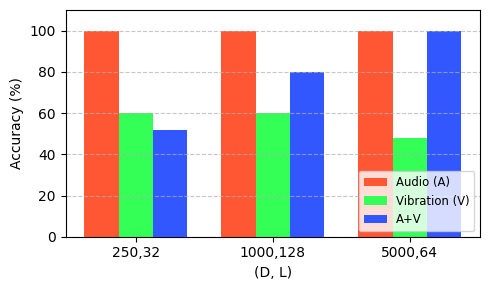

In [45]:

# Data
configs = ["250,32", "1000,128", "5000,64"]
types = ["Audio (A)", "Vibration (V)", "A+V"]
acc_values = [
    [100, 60, 52],   # for 250,32
    [100, 60, 80],   # for 1000,128
    [100, 48, 100]   # for 5000,64
]

# Plotting setup
x = np.arange(len(configs))  # label locations
width = 0.25  # width of the bars

# Generate positions for each type
offsets = [-width, 0, width]
# colors = ["#4a90e2", "#357ABD", "#1f4e79"]
# use R, G, B
colors = ["#FF5733", "#33FF57", "#3357FF"]

fig, ax = plt.subplots(figsize=(5, 3))

# Plot each type
for i, (label, offset, color) in enumerate(zip(types, offsets, colors)):
    acc = [acc_values[j][i] for j in range(len(configs))]
    ax.bar(x + offset, acc, width, label=label, color=color)

# Formatting
# ax.set_title("Accuracy by Type and (D,L) Configuration")
ax.set_xlabel("(D, L)")
ax.set_ylabel("Accuracy (%)")
ax.set_xticks(x)
ax.set_xticklabels(configs)
ax.set_ylim(0, 110)
ax.legend(title="Type")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
# legend on right bottom
plt.legend(loc='lower right', fontsize='small', title_fontsize='medium')
plt.savefig("compare_modalities.pdf", bbox_inches='tight')

plt.show()


## Visualisation of features

Classes:  ['cloth', 'grass', 'metal', 'sandpaper', 'wood']


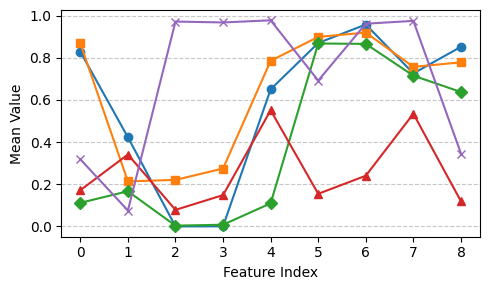

In [200]:
# Load dataset
dataset = [] # audio features
labels = [] # class ids

audio_files, classes = load_dataset("train", modality="audio")

# Prepare a dictionary of labels and their IDs
label_to_id = {class_name: idx for idx, class_name in enumerate(classes)}
id_to_label = {idx: class_name for class_name, idx in label_to_id.items()}

# Extract features
for _, class_name in enumerate(classes):
    for file_path in audio_files[class_name]:
        features = extract_audio_features(file_path, sr=8000)
        dataset.append(features)
        labels.append(label_to_id[class_name])


# Normalize feature-wise (0–1 scaling)
dataset = np.array(dataset)
# save the (min, max) values for each feature
dataset_min = np.min(dataset, axis=0)
dataset_max = np.max(dataset, axis=0)
dataset = (dataset - dataset.min(axis=0)) / (dataset.max(axis=0) - dataset.min(axis=0))

# datapoints shapes for visualization
shapes = ["o", "s", "D", "^", "x"]
fig, ax = plt.subplots(figsize=(5, 3))
for i in range(len(classes)):
    mean_values = np.mean(dataset[30*i:30*i+30], axis=0)
    ax.plot(range(len(mean_values)), mean_values, label=id_to_label[i], marker=shapes[i % len(shapes)])
# ax.set_title("Mean Feature Values for Each Class")
ax.set_xlabel("Feature Index")
ax.set_ylabel("Mean Value")
# ax.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
# save the plot
plt.savefig("audio_feature_values.pdf", bbox_inches='tight')
plt.show()

Classes:  ['cloth', 'grass', 'metal', 'sandpaper', 'wood']


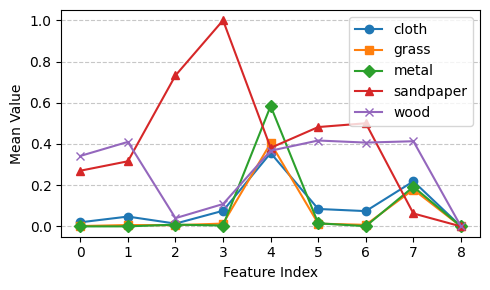

In [201]:
import matplotlib.pyplot as plt
import pandas as pd
# Load dataset
dataset = [] # audio features
labels = [] # class ids

audio_files, classes = load_dataset(type="train", modality="vibration")

{
# # all files are csv, so load and visualise all the files of a class in a single plot. and each subplot should be a different class
# fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

# for idx, class_name in enumerate(classes):
#     # Load all CSV files of a class from audio_files
#     csv_files = audio_files[class_name]
#     ax = axes[idx]
#     for i, file_path in enumerate(csv_files):
#         df = pd.read_csv(file_path, header=None)
#         x = df.iloc[:, 0].to_numpy()
#         # clip the max and min values to 1024 and 0
#         x = np.clip(x, 0, 1024)
#         ax.plot(x, label=f"File {i+1}")
#     ax.set_title(f"Vibration Data for Class: {class_name}")
#     ax.set_ylabel("Amplitude")
#     # ax.legend(loc="upper right", fontsize="small")

# axes[-1].set_xlabel("Time")
# plt.tight_layout()
# plt.show()
}


# Prepare a dictionary of labels and their IDs
label_to_id = {class_name: idx for idx, class_name in enumerate(classes)}
id_to_label = {idx: class_name for class_name, idx in label_to_id.items()}

# Extract features
for _, class_name in enumerate(classes):
    for file_path in audio_files[class_name]:
        # features = extract_audio_features(file_path, sr=8000)
        features = extract_vibration_features(file_path, frame_length=2048, hop_length=512)

        dataset.append(features)
        labels.append(label_to_id[class_name])

# print mean of features for a class
dataset = np.array(dataset) 
# save the (min, max) values for each feature
dataset_min = np.min(dataset, axis=0)
dataset_max = np.max(dataset, axis=0)

# Avoid normalizing the last column as all values are the same
for i in range(dataset.shape[1] - 1):
    dataset[:, i] = (dataset[:, i] - dataset_min[i]) / (dataset_max[i] - dataset_min[i])

# plot the mean of features for each class
# a single plot with x-axis as the feature index and y-axis as the mean value. PLot all the classes in a single plot
shapes = ["o", "s", "D", "^", "x"]

fig, ax = plt.subplots(figsize=(5, 3))
for i in range(len(classes)):
    mean_values = np.mean(dataset[30*i:30*i+30], axis=0)
    ax.plot(range(len(mean_values)), mean_values, label=id_to_label[i], marker=shapes[i % len(shapes)])
# ax.set_title("Mean Feature Values for Each Class")
ax.set_xlabel("Feature Index")
ax.set_ylabel("Mean Value")
ax.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("vibration_feature_values.pdf", bbox_inches='tight')
plt.show()

## Accuracy vs Epoch for different D values

In [198]:
# --- Main execution ---

# Load dataset
dataset = [] # audio features
labels = [] # class ids

audio_files, classes = load_dataset("train")

# Prepare a dictionary of labels and their IDs
label_to_id = {class_name: idx for idx, class_name in enumerate(classes)}
id_to_label = {idx: class_name for class_name, idx in label_to_id.items()}

# Extract features
for _, class_name in enumerate(classes):
    for file_path in audio_files[class_name]:
        features = extract_audio_features(file_path, sr=8000)
        dataset.append(features)
        labels.append(label_to_id[class_name])


# Normalize feature-wise (0–1 scaling)
dataset = np.array(dataset)
dataset = (dataset - dataset.min(axis=0)) / (dataset.max(axis=0) - dataset.min(axis=0))

# generate codebooks
D = 100  # Hypervector dimensionality
LEVELS = 64 # quantization levels

D_values = [2**2, 2**4, 2**6, 2**8, 2**10, 2**12] # levels
# D_values = [2**6, 2**8, 2**10, 2**12]
# D_values = [10, 50, 100, 500, 1000, 1000] # D
accuracy_values = []

for LEVELS in D_values:
    np.random.seed(42)
    codebook = generate_feature_codebook(feature_names, D)
    value_level_hvs = generate_value_level_hvs(LEVELS, D)

    vectors = [] # encode dataset vectors

    for features in dataset:
        encoded_hv = encode_feature_vector(features, codebook, value_level_hvs, D, LEVELS)
        vectors.append(encoded_hv)

    vectors = np.array(vectors)
    labels = np.array(labels)


    # create weights folder if it doesn't exist
    # if not os.path.exists("weights"):
    #     os.makedirs("weights")

    accuracys = []
    for i in range(10):
        # train the classifier
        class_hvs = train_hd_classifier(vectors, labels, codebook, value_level_hvs, D, LEVELS, epochs=i+1)
        
        acc = evaluate_hd(vectors, labels, class_hvs)
        accuracys.append(acc*100)
        # print(f"{i+1}: Training accuracy: {acc * 100:.2f}%")
    accuracy_values.append(accuracys)



Classes:  ['cloth', 'grass', 'metal', 'sandpaper', 'wood']


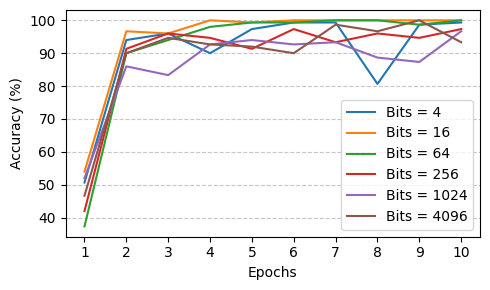

In [199]:
# --- Plotting the results ---
plt.figure(figsize=(5, 3))
for i, D in enumerate(D_values):
    plt.plot(range(1, len(accuracys)+1), accuracy_values[i], label=f'Bits = {D}')
    # plt.plot(range(1, len(accuracys)+1), accuracy_values[i], label=f'D = {D}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
# plt.title('Training Accuracy vs Epochs for Different D Values')
plt.xticks(range(1, len(accuracys)+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig("LvsAcc.pdf", bbox_inches='tight')


## Memory Calculator

Codebook: D*f bytes
Class_hv: D*n bytes
level_hv: D*l bytes

In [54]:
# calculate the memory usage for a given D, LEVELS, number of classes, number of features

def calculate_memory_usage(D, LEVELS, num_classes, num_features):
    # Memory usage for class hypervectors
    class_hvs_memory = D * num_classes * (1) / (1024 ** 1)  # in KB (1 byte per bool)
    
    # Memory usage for codebook
    codebook_memory = D * num_features * (1) / (1024 ** 1) # in KB (1 byte per bool)
    
    # Memory usage for value level hypervectors
    value_level_hvs_memory = LEVELS * D * (1)  / (1024 ** 1)  # in KB (1 byte per bool)
    
    total_memory = class_hvs_memory + codebook_memory + value_level_hvs_memory
    
    return total_memory

# Example usage
D = 250
LEVELS = 32
num_classes = 5
num_features = 9

memory_usage = calculate_memory_usage(D, LEVELS, num_classes, num_features)
print(f"Total Memory Usage: {memory_usage:.2f} KB")

Total Memory Usage: 11.23 KB
